In [1]:
import numpy as np
from PIL import Image
from src.auxFunctions import deconstruct, reconstruct
from library import hrNet
import tensorflow as tf

2023-05-18 12:15:55.235397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 12:15:55.366786: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 12:15:55.392312: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-18 12:15:55.790073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [ ]:
modelWeights = 'results/HRNET_CAMBI_ALPHA2.5e-06_FINAL.h5'
#modelWeights = 'results/HRNET_CAMBI_ALPHA1.0.h5'
im = Image.open('000001_0750.png')
rgb = np.array(im.convert('RGB')) / 255.0

In [ ]:
RGBpatches = deconstruct(rgb)
_numPatches = RGBpatches.shape[0]
print(_numPatches)

inputPatches = np.concatenate((RGBpatches,RGBpatches,RGBpatches),axis=-1)
outputPatches = np.empty((_numPatches,192,192,3))
hrNetModel = hrNet(2, [32, 64, 128, 256], 5).model()
hrNetModel.load_weights(modelWeights)
print(f"GPUS: {tf.config.list_physical_devices('GPU')}")

BATCHSIZE = 1
NUMSTEPS = _numPatches // BATCHSIZE
print(NUMSTEPS)

for _step in range(NUMSTEPS):
    print("Step: ",_step)
    inputPatch = inputPatches[_step * BATCHSIZE : _step * BATCHSIZE + BATCHSIZE,:,:,:]
    outputPatches[_step * BATCHSIZE : _step * BATCHSIZE + BATCHSIZE,:,:,:] = hrNetModel(tf.convert_to_tensor(inputPatch), training=False)

# Patches left to process
if (_numPatches) > (BATCHSIZE * NUMSTEPS):
    inputPatch = inputPatches[NUMSTEPS * BATCHSIZE: -1,:,:,:]
    outputPatches[NUMSTEPS * BATCHSIZE: -1,:,:,:] = hrNetModel(tf.convert_to_tensor(inputPatch), training=False)

rgbRes = reconstruct(outputPatches,rgb,192) * 255.0
im_res = Image.fromarray(np.uint8(rgbRes))
im_res.save("HrNet_restored.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


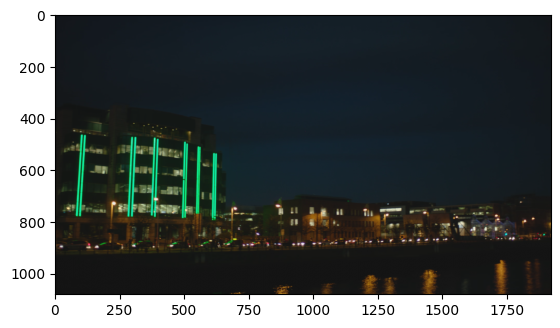

In [3]:
from src.auxFunctions import readYUV420Range, YUV2RGB
import matplotlib.pyplot as plt
Y, U, V = readYUV420Range("validSetDegClip/A007C036_171117_R2HN_5_AV1_CRF26_.yuv",(1920,1080),(0,0),True)
YUV = np.stack((Y,U,V),axis=-1)
RGB = YUV2RGB(YUV[0])
plt.imsave("Dublin.png",np.uint8(RGB))
plt.imshow(RGB/255)

In [6]:
import glob
import pandas as pd

#print(glob.glob("/home/nwaliv/MAIProject-main/dataset/*"))

imageList = glob.glob("/home/nwaliv/MAIProject-main/testSetRefClip/*.yuv")
print(imageList)
DATAFRAME = pd.read_csv("dataFrames/testVideoSet.csv")
compPath = 'testSetRefClip/'
outputPath ='testSetRefFrame/'

# for _num, item in enumerate(imageList):
#     print(item)
#     Y, U, V = readYUV420Range("validSetDegClip/A007C036_171117_R2HN_5_AV1_CRF26_.yuv",(1920,1080),(0,0),True)
#     YUV = np.stack((Y,U,V),axis=-1)
#     RGB = YUV2RGB(YUV[0])
#     plt.imsave("Dublin.png",np.uint8(RGB))


for cnt, index in enumerate(range(DATAFRAME.shape[0])):

    _comp = DATAFRAME['Ref'][index]
    print(_comp)
    _height = DATAFRAME['Height'][index]
    _width = DATAFRAME['Width'][index]
    Y, U, V = readYUV420Range(compPath+_comp ,(_width,_height),(0,0),True)
    YUV = np.stack((Y,U,V),axis=-1)
    RGB = YUV2RGB(YUV[0])
    plt.imsave(outputPath +_comp + ".png",np.uint8(RGB))

['/home/nwaliv/MAIProject-main/testSetRefClip/DFireS71Mitch_480x272_24fps_10bit_420.yuv', '/home/nwaliv/MAIProject-main/testSetRefClip/BHamsterBVIHFR_1920x1088_120fps_10bit_420.yuv', '/home/nwaliv/MAIProject-main/testSetRefClip/AStreetDancerS5IRIS_3840x2176_24fps_10bit_420.yuv', '/home/nwaliv/MAIProject-main/testSetRefClip/A007C041_171117_R2HN_3.yuv', '/home/nwaliv/MAIProject-main/testSetRefClip/CSGO_11.yuv', '/home/nwaliv/MAIProject-main/testSetRefClip/svt_smoke_sauna_3840x2160_50_10bit_420.yuv', '/home/nwaliv/MAIProject-main/testSetRefClip/FlowingRiverLowSpeedLowGran_300frames_1920x1080.yuv', '/home/nwaliv/MAIProject-main/testSetRefClip/MINECRAFT_4.yuv', '/home/nwaliv/MAIProject-main/testSetRefClip/aom_nocturne_3840x2160_60_hdr10_9010-9349.yuv', '/home/nwaliv/MAIProject-main/testSetRefClip/HexagonTileLowSpeedLowGran_300frames_1920x1080.yuv', '/home/nwaliv/MAIProject-main/testSetRefClip/Dolby_Atmos_Natures_Fury_1920x1080_ATMOS_71-thedigitaltheater_7.yuv', '/home/nwaliv/MAIProject-main

In [19]:
import os
from library.GeneralOps import runTerminalCmd
from src.rgb2yuv_yuv2rgb import RGB2YUV
from library.GeneralOps import writeYUV420
baseRefPath = '/home/nwaliv/MAIProject-main/testSetRefFrame/'
baseCompPath = '/home/nwaliv/MAIProject-main/deepDeband-fRestoredImages/'


df_deepDeband = {
    'Ref': [],
    'Comp': [],
    'Height': [],
    'Width': [],
    'PSNR_Y': [],
    'PSNR_Cb': [],
    'PSNR_Cr': [],
    'PSNR_Y': [],
    'SSIM': [],
    'VMAF': [],
    'CAMBI': []
    }

DATAFRAME = pd.read_csv('dataFrames/testVideoSet.csv')
for _idx, _row in DATAFRAME.iterrows():
    _height = _row['Height']
    _width = _row['Width']
    _comp = os.path.join(baseCompPath,_row['Comp']+".png")
    _ref = os.path.join(baseRefPath, _row['Ref']+".png")

    im = Image.open(_comp)
    rgb_comp = np.array(im.convert('RGB'))
    yuv_comp = RGB2YUV(rgb_comp).astype(np.uint8)
    writeYUV420("processing/ImageDeg.yuv",yuv_comp[:,:,0],yuv_comp[:,:,1],yuv_comp[:,:,2],False)

    im = Image.open(_ref)
    rgb_ref = np.array(im.convert('RGB'))
    yuv_ref = RGB2YUV(rgb_ref).astype(np.uint8)
    writeYUV420("processing/ImageRef.yuv",yuv_ref[:,:,0],yuv_ref[:,:,1],yuv_ref[:,:,2],False)

    print('dd_'+_row['Comp'])
    runTerminalCmd(f"vmaf -r processing/ImageRef.yuv -d processing/ImageDeg.yuv -w {_width} -h {_height} -p 420 -b 8 --csv -o processing/evals.csv --feature psnr --feature float_ssim --feature cambi -q")
    _cambi = pd.read_csv('processing/evals.csv')['cambi'].mean()
    print(_cambi)
    _psnr_y = pd.read_csv('processing/evals.csv')['psnr_y'].mean()
    _psnr_cb = pd.read_csv('processing/evals.csv')['psnr_cb'].mean()
    _psnr_cr = pd.read_csv('processing/evals.csv')['psnr_cr'].mean()
    _ssim = pd.read_csv('processing/evals.csv')['float_ssim'].mean()
    _vmaf = pd.read_csv('processing/evals.csv')['vmaf'].mean()
    df_deepDeband['Ref'].append(_row['Ref'])
    df_deepDeband['Comp'].append('dd'+_row['Comp'])
    df_deepDeband['Height'].append(_height)
    df_deepDeband['Width'].append(_width)
    df_deepDeband['PSNR_Y'].append(_psnr_y)
    df_deepDeband['PSNR_Cb'].append(_psnr_cb)
    df_deepDeband['PSNR_Cr'].append(_psnr_cr)
    df_deepDeband['SSIM'].append(_ssim)
    df_deepDeband['VMAF'].append(_vmaf)
    df_deepDeband['CAMBI'].append(_cambi)
    
df_deepDeband = pd.DataFrame(df_deepDeband)
df_deepDeband.to_csv('dataFrames/deepDebandFScores.csv')

dd_A007C041_171117_R2HN_3_H265_CRF41_.yuv
0.0
dd_A007C041_171117_R2HN_3_H265_CRF31_.yuv
0.0
dd_A007C041_171117_R2HN_3_H265_CRF51_.yuv
0.0
dd_A007C041_171117_R2HN_3_H265_CRF21_.yuv
0.0
dd_A007C041_171117_R2HN_3_AV1_CRF63_.yuv
0.0
dd_A007C041_171117_R2HN_3_AV1_CRF51_.yuv
0.0
dd_A007C041_171117_R2HN_3_AV1_CRF38_.yuv
0.0
dd_A007C041_171117_R2HN_3_AV1_CRF26_.yuv
0.0
dd_A007C041_171117_R2HN_3_AV1_CRF13_.yuv
0.0
dd_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_H264_CRF31_.yuv
0.0
dd_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_H265_CRF41_.yuv
0.0
dd_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_H265_CRF51_.yuv
0.0
dd_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_AV1_CRF63_.yuv
0.0
dd_ABubblesPitcherS1BVITexture_3840x2176_120fps_10bit_420_AV1_CRF63_.yuv
0.0
dd_ABubblesPitcherS1BVITexture_3840x2176_120fps_10bit_420_AV1_CRF51_.yuv
0.0
dd_ABubblesPitcherS1BVITexture_3840x2176_120fps_10bit_420_AV1_CRF38_.yuv
0.0
dd_ABubblesPitcherS1BVITexture_3840x2176_120f

In [16]:
import os
from library.GeneralOps import runTerminalCmd
from src.rgb2yuv_yuv2rgb import RGB2YUV
from library.GeneralOps import writeYUV420
baseRefPath = '/home/nwaliv/MAIProject-main/testSetRefClip/'
baseCompPath = '/home/nwaliv/MAIProject-main/testSetRestored/'


df_hrNet = {
    'Ref': [],
    'Comp': [],
    'Height': [],
    'Width': [],
    'PSNR_Y': [],
    'PSNR_Cb': [],
    'PSNR_Cr': [],
    'PSNR_Y': [],
    'SSIM': [],
    'VMAF': [],
    'CAMBI': []
    }

DATAFRAME = pd.read_csv('dataFrames/testVideoSet.csv')
for _idx, _row in DATAFRAME.iterrows():
    _height = _row['Height']
    _width = _row['Width']
    _comp = os.path.join(baseCompPath,"res_" +_row['Comp'])
    _ref = os.path.join(baseRefPath, _row['Ref'])

    # im = Image.open(_comp)
    # rgb_comp = np.array(im.convert('RGB'))
    # yuv_comp = RGB2YUV(rgb_comp).astype(np.uint8)
    # writeYUV420("processing/ImageDeg.yuv",yuv_comp[:,:,0],yuv_comp[:,:,1],yuv_comp[:,:,2],False)
    YUV = readYUV420Range(_comp,(_width,_height),(0,0),True)
    writeYUV420("processing/ImageDeg.yuv",YUV[0],YUV[1],YUV[2],True)

    YUV = readYUV420Range(_ref,(_width,_height),(0,0),True)
    writeYUV420("processing/ImageRef.yuv",YUV[0],YUV[1],YUV[2],True)
    # im = Image.open(_ref)
    # rgb_ref = np.array(im.convert('RGB'))
    # yuv_ref = RGB2YUV(rgb_ref).astype(np.uint8)
    # writeYUV420("processing/ImageRef.yuv",yuv_ref[:,:,0],yuv_ref[:,:,1],yuv_ref[:,:,2],False)

    print('hr_'+_row['Comp'])
    runTerminalCmd(f"vmaf -r processing/ImageRef.yuv -d processing/ImageDeg.yuv -w {_width} -h {_height} -p 420 -b 8 --csv -o processing/evals.csv --feature psnr --feature float_ssim --feature cambi -q")
    _cambi = pd.read_csv('processing/evals.csv')['cambi'].mean()
    print(_cambi)
    _psnr_y = pd.read_csv('processing/evals.csv')['psnr_y'].mean()
    _psnr_cb = pd.read_csv('processing/evals.csv')['psnr_cb'].mean()
    _psnr_cr = pd.read_csv('processing/evals.csv')['psnr_cr'].mean()
    _ssim = pd.read_csv('processing/evals.csv')['float_ssim'].mean()
    _vmaf = pd.read_csv('processing/evals.csv')['vmaf'].mean()
    df_hrNet['Ref'].append(_row['Ref'])
    df_hrNet['Comp'].append('hr_'+_row['Comp'])
    df_hrNet['Height'].append(_height)
    df_hrNet['Width'].append(_width)
    df_hrNet['PSNR_Y'].append(_psnr_y)
    df_hrNet['PSNR_Cb'].append(_psnr_cb)
    df_hrNet['PSNR_Cr'].append(_psnr_cr)
    df_hrNet['SSIM'].append(_ssim)
    df_hrNet['VMAF'].append(_vmaf)
    df_hrNet['CAMBI'].append(_cambi)
    
df_hrNet = pd.DataFrame(df_hrNet)
df_hrNet.to_csv('dataFrames/hrNetImgScores.csv')

hr_A007C041_171117_R2HN_3_H265_CRF41_.yuv
4.099539
hr_A007C041_171117_R2HN_3_H265_CRF31_.yuv
4.395829
hr_A007C041_171117_R2HN_3_H265_CRF51_.yuv
3.377978
hr_A007C041_171117_R2HN_3_H265_CRF21_.yuv
3.94605
hr_A007C041_171117_R2HN_3_AV1_CRF63_.yuv
4.476528
hr_A007C041_171117_R2HN_3_AV1_CRF51_.yuv
4.432842
hr_A007C041_171117_R2HN_3_AV1_CRF38_.yuv
4.444498
hr_A007C041_171117_R2HN_3_AV1_CRF26_.yuv
4.162954
hr_A007C041_171117_R2HN_3_AV1_CRF13_.yuv
2.387397
hr_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_H264_CRF31_.yuv
2.048507
hr_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_H265_CRF41_.yuv
2.378526
hr_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_H265_CRF51_.yuv
2.786764
hr_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_AV1_CRF63_.yuv
2.321057
hr_ABubblesPitcherS1BVITexture_3840x2176_120fps_10bit_420_AV1_CRF63_.yuv
9.840976
hr_ABubblesPitcherS1BVITexture_3840x2176_120fps_10bit_420_AV1_CRF51_.yuv
9.976307
hr_ABubblesPitcherS1BVITexture_3840x2176_120fps_

In [20]:
import os
from library.GeneralOps import runTerminalCmd
from src.rgb2yuv_yuv2rgb import RGB2YUV
from library.GeneralOps import writeYUV420
baseRefPath = '/home/nwaliv/MAIProject-main/testSetRefClip/'
baseCompPath = '/home/nwaliv/MAIProject-main/adabandVideos/'


df_adaband = {
    'Ref': [],
    'Comp': [],
    'Height': [],
    'Width': [],
    'PSNR_Y': [],
    'PSNR_Cb': [],
    'PSNR_Cr': [],
    'PSNR_Y': [],
    'SSIM': [],
    'VMAF': [],
    'CAMBI': []
    }

DATAFRAME = pd.read_csv('dataFrames/testVideoSet.csv')
for _idx, _row in DATAFRAME.iterrows():
    _height = _row['Height']
    _width = _row['Width']
    _comp = os.path.join(baseCompPath,"adaband_" +_row['Comp'])
    _ref = os.path.join(baseRefPath, _row['Ref'])

    # im = Image.open(_comp)
    # rgb_comp = np.array(im.convert('RGB'))
    # yuv_comp = RGB2YUV(rgb_comp).astype(np.uint8)
    # writeYUV420("processing/ImageDeg.yuv",yuv_comp[:,:,0],yuv_comp[:,:,1],yuv_comp[:,:,2],False)
    YUV = readYUV420Range(_comp,(_width,_height),(0,0),True)
    writeYUV420("processing/ImageDeg.yuv",YUV[0],YUV[1],YUV[2],True)

    YUV = readYUV420Range(_ref,(_width,_height),(0,0),True)
    writeYUV420("processing/ImageRef.yuv",YUV[0],YUV[1],YUV[2],True)
    # im = Image.open(_ref)
    # rgb_ref = np.array(im.convert('RGB'))
    # yuv_ref = RGB2YUV(rgb_ref).astype(np.uint8)
    # writeYUV420("processing/ImageRef.yuv",yuv_ref[:,:,0],yuv_ref[:,:,1],yuv_ref[:,:,2],False)

    print('ab_'+_row['Comp'])
    runTerminalCmd(f"vmaf -r processing/ImageRef.yuv -d processing/ImageDeg.yuv -w {_width} -h {_height} -p 420 -b 8 --csv -o processing/evals.csv --feature psnr --feature float_ssim --feature cambi -q")
    _cambi = pd.read_csv('processing/evals.csv')['cambi'].mean()
    print(_cambi)
    _psnr_y = pd.read_csv('processing/evals.csv')['psnr_y'].mean()
    _psnr_cb = pd.read_csv('processing/evals.csv')['psnr_cb'].mean()
    _psnr_cr = pd.read_csv('processing/evals.csv')['psnr_cr'].mean()
    _ssim = pd.read_csv('processing/evals.csv')['float_ssim'].mean()
    _vmaf = pd.read_csv('processing/evals.csv')['vmaf'].mean()
    df_adaband['Ref'].append(_row['Ref'])
    df_adaband['Comp'].append('ab_'+_row['Comp'])
    df_adaband['Height'].append(_height)
    df_adaband['Width'].append(_width)
    df_adaband['PSNR_Y'].append(_psnr_y)
    df_adaband['PSNR_Cb'].append(_psnr_cb)
    df_adaband['PSNR_Cr'].append(_psnr_cr)
    df_adaband['SSIM'].append(_ssim)
    df_adaband['VMAF'].append(_vmaf)
    df_adaband['CAMBI'].append(_cambi)
    
df_adaband = pd.DataFrame(df_adaband)
df_adaband.to_csv('dataFrames/adabandImgScores.csv')

ab_A007C041_171117_R2HN_3_H265_CRF41_.yuv
0.01008
ab_A007C041_171117_R2HN_3_H265_CRF31_.yuv
0.005002
ab_A007C041_171117_R2HN_3_H265_CRF51_.yuv
0.004483
ab_A007C041_171117_R2HN_3_H265_CRF21_.yuv
0.004834
ab_A007C041_171117_R2HN_3_AV1_CRF63_.yuv
0.005048
ab_A007C041_171117_R2HN_3_AV1_CRF51_.yuv
0.009357
ab_A007C041_171117_R2HN_3_AV1_CRF38_.yuv
0.009092
ab_A007C041_171117_R2HN_3_AV1_CRF26_.yuv
0.003646
ab_A007C041_171117_R2HN_3_AV1_CRF13_.yuv
0.007742
ab_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_H264_CRF31_.yuv
0.02895
ab_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_H265_CRF41_.yuv
0.011679
ab_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_H265_CRF51_.yuv
0.021909
ab_ABasketballS3YonseiUniversity_3840x2176_30fps_10bit_420_AV1_CRF63_.yuv
0.013873
ab_ABubblesPitcherS1BVITexture_3840x2176_120fps_10bit_420_AV1_CRF63_.yuv
0.000292
ab_ABubblesPitcherS1BVITexture_3840x2176_120fps_10bit_420_AV1_CRF51_.yuv
0.00053
ab_ABubblesPitcherS1BVITexture_3840x2176_120fps_10

In [ ]:
import os
from library.GeneralOps import runTerminalCmd
from src.rgb2yuv_yuv2rgb import RGB2YUV
from library.GeneralOps import writeYUV420
baseRefPath = '/home/nwaliv/MAIProject-main/testSetRefClip/'
baseCompPath = '/home/nwaliv/MAIProject-main/testSetDegClip/'


df_adaband = {
    'Ref': [],
    'Comp': [],
    'Height': [],
    'Width': [],
    'PSNR_Y': [],
    'PSNR_Cb': [],
    'PSNR_Cr': [],
    'PSNR_Y': [],
    'SSIM': [],
    'VMAF': [],
    'CAMBI': []
    }

DATAFRAME = pd.read_csv('dataFrames/testVideoSet.csv')
for _idx, _row in DATAFRAME.iterrows():
    _height = _row['Height']
    _width = _row['Width']
    _comp = os.path.join(baseCompPath,_row['Comp'])
    _ref = os.path.join(baseRefPath, _row['Ref'])

    # im = Image.open(_comp)
    # rgb_comp = np.array(im.convert('RGB'))
    # yuv_comp = RGB2YUV(rgb_comp).astype(np.uint8)
    # writeYUV420("processing/ImageDeg.yuv",yuv_comp[:,:,0],yuv_comp[:,:,1],yuv_comp[:,:,2],False)
    YUV = readYUV420Range(_comp,(_width,_height),(0,0),True)
    writeYUV420("processing/ImageDeg.yuv",YUV[0],YUV[1],YUV[2],True)

    YUV = readYUV420Range(_ref,(_width,_height),(0,0),True)
    writeYUV420("processing/ImageRef.yuv",YUV[0],YUV[1],YUV[2],True)
    # im = Image.open(_ref)
    # rgb_ref = np.array(im.convert('RGB'))
    # yuv_ref = RGB2YUV(rgb_ref).astype(np.uint8)
    # writeYUV420("processing/ImageRef.yuv",yuv_ref[:,:,0],yuv_ref[:,:,1],yuv_ref[:,:,2],False)

    print(_row['Comp'])
    runTerminalCmd(f"vmaf -r processing/ImageRef.yuv -d processing/ImageDeg.yuv -w {_width} -h {_height} -p 420 -b 8 --csv -o processing/evals.csv --feature psnr --feature float_ssim --feature cambi -q")
    _cambi = pd.read_csv('processing/evals.csv')['cambi'].mean()
    print(_cambi)
    _psnr_y = pd.read_csv('processing/evals.csv')['psnr_y'].mean()
    _psnr_cb = pd.read_csv('processing/evals.csv')['psnr_cb'].mean()
    _psnr_cr = pd.read_csv('processing/evals.csv')['psnr_cr'].mean()
    _ssim = pd.read_csv('processing/evals.csv')['float_ssim'].mean()
    _vmaf = pd.read_csv('processing/evals.csv')['vmaf'].mean()
    df_adaband['Ref'].append(_row['Ref'])
    df_adaband['Comp'].append(_row['Comp'])
    df_adaband['Height'].append(_height)
    df_adaband['Width'].append(_width)
    df_adaband['PSNR_Y'].append(_psnr_y)
    df_adaband['PSNR_Cb'].append(_psnr_cb)
    df_adaband['PSNR_Cr'].append(_psnr_cr)
    df_adaband['SSIM'].append(_ssim)
    df_adaband['VMAF'].append(_vmaf)
    df_adaband['CAMBI'].append(_cambi)
    
df_adaband = pd.DataFrame(df_adaband)
df_adaband.to_csv('dataFrames/compImgScores.csv')